In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import animation
from mpl_toolkits.basemap import Basemap
import contextily as cx  
import ERA_5_analysis_support as era5
import xarray as xr
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial import cKDTree
from datetime import datetime
from matplotlib import gridspec
from sklearn.metrics import r2_score
#import 
%matplotlib inline

In [44]:
base_path = "/gpfs/work3/0/ai4nbs/hurry_wave/north_sea"

# parser = argparse.ArgumentParser(description="Postprocess Hurrywave output.")
# parser.add_argument("--model_name", type=str, required=True, help="Name of the model run")
# parser.add_argument("--data_name", type=str, required=True, help="Name of the data set")
# args = parser.parse_args()

# model_name = args.model_name
# data_name = args.data_name

model_name = 'spinup_test_nowind'

area = [65, -12, 48, 10] # DCSM area in the North Sea (degrees): North, West, South, East

model_path = os.path.join(base_path, '04_modelruns',model_name)


inp_file = os.path.join(model_path, 'hurrywave.inp')
tstart = None
tstop = None

# DCSM bounding box: [North, West, South, East]
area = [65, -12, 48, 10]  # (N, W, S, E)

# Find the start and stop times from the input file
with open(inp_file, 'r') as f:
    for line in f:
        if line.strip().startswith('tstart'):
            tstart = line.split('=')[1].strip()
        if line.strip().startswith('tstop'):
            tstop = line.split('=')[1].strip()


# Ensure time is in "yyyymmdd hhmmss" format
def parse_time(s):
    parts = s.strip().split()
    if len(parts) == 2:
        date, time = parts
    elif len(parts) == 1:
        date = parts[0][:8]
        time = parts[0][8:] if len(parts[0]) > 8 else "000000"
    else:
        date, time = "00000000", "000000"  # fallback
    return f"{date} {time}"

tstart_str = parse_time(tstart)
tstop_str = parse_time(tstop)

tstart_dt = datetime.strptime(tstart_str, "%Y%m%d %H%M%S")
tstop_dt = datetime.strptime(tstop_str, "%Y%m%d %H%M%S")

In [45]:
def read_station_names_from_obs(file_path):
    names = []
    with open(file_path, 'r') as f:
        for line in f:
            if '#' in line:
                name = line.split('# ')[1].strip()
                names.append(name)
    return names

obs_file_path = os.path.join(model_path, 'hurrywave.obs')
station_names = read_station_names_from_obs(obs_file_path)

In [46]:
### Post-process Hurrywave results
# Get the results from the netcdf file

map_file = os.path.join(model_path,'hurrywave_map.nc')
his_file = os.path.join(model_path,'hurrywave_his.nc')


output_dir = os.path.join(model_path, '1_postprocessing')
if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)

xr_nc = xr.open_dataset(map_file , decode_times=True)

modig = {"msk": xr_nc["msk"],
         "zb": xr_nc["zb"],
         "Hm0": xr_nc["hm0"],
         #"Hm0_max": xr_nc["hm0max"],
         "Tp": xr_nc["tp"],
         "DIR": xr_nc["wavdir"],
         "ds": xr_nc["dirspr"],
         #"windspeed": xr_nc["windspeed"]
        }

# Assuming "time" is available in modig dictionary
time_variable =  xr_nc["time"]

xr_nc.close()

his = xr.open_dataset(his_file)
his = his.assign_coords({"stations": station_names})
# his = his.assign_coords({"stations": [x.decode("utf-8").strip() for x in his.station_name.values]})

In [47]:
def extract_data(ds: xr.Dataset):
    """
    Extract data from xarray Dataset into nested dictionary:
    df['stationname']['variablename'].values

    Parameters:
    - ds: xarray.Dataset with a 'stations' coordinate

    Returns:
    - dict of dicts: df[station][variable] = values
    """
    nested_dict = {}
    
    for station in ds.stations.values:
        station_data = ds.sel(stations=station)
        nested_dict[station] = {}
        
        for var in ds.data_vars:
            nested_dict[station][var] = station_data[var].values

        # Include coordinates like "time" in the extraction
        for coord in ds.coords:
            nested_dict[station][coord] = station_data[coord].values
            
    return nested_dict


df_model = extract_data(his)
station_list_model = list(df_model.keys())

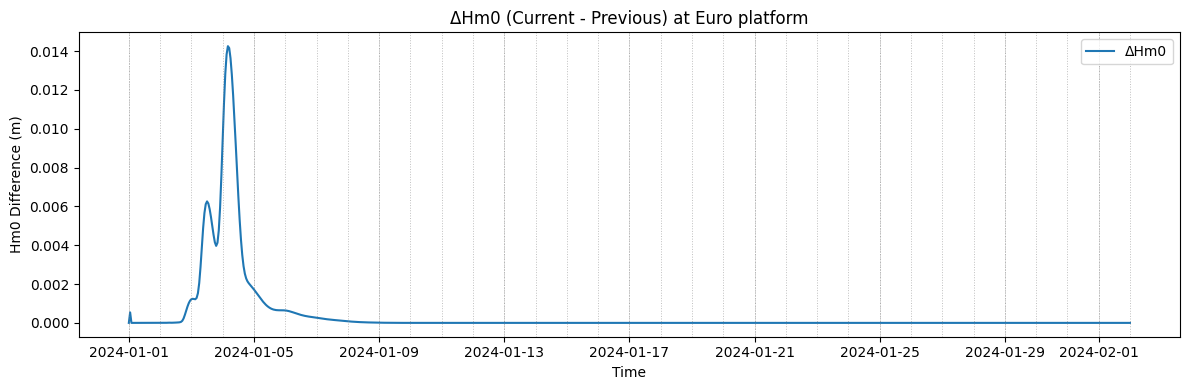

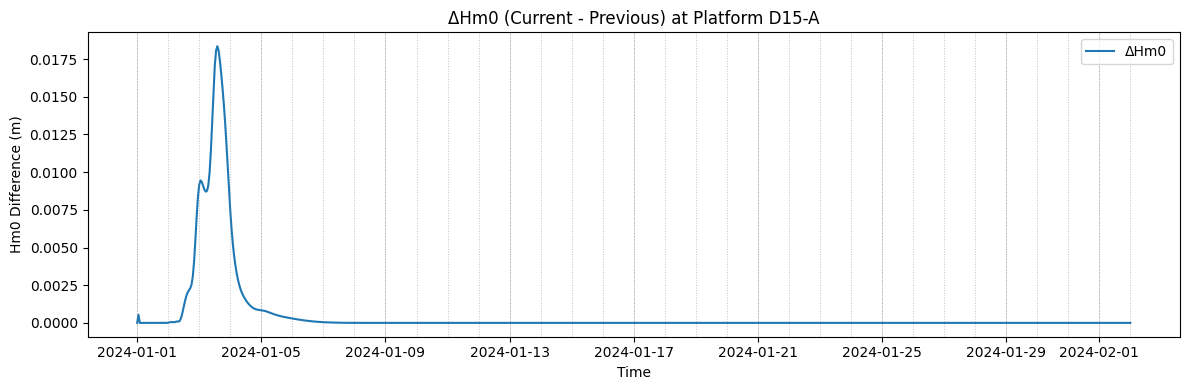

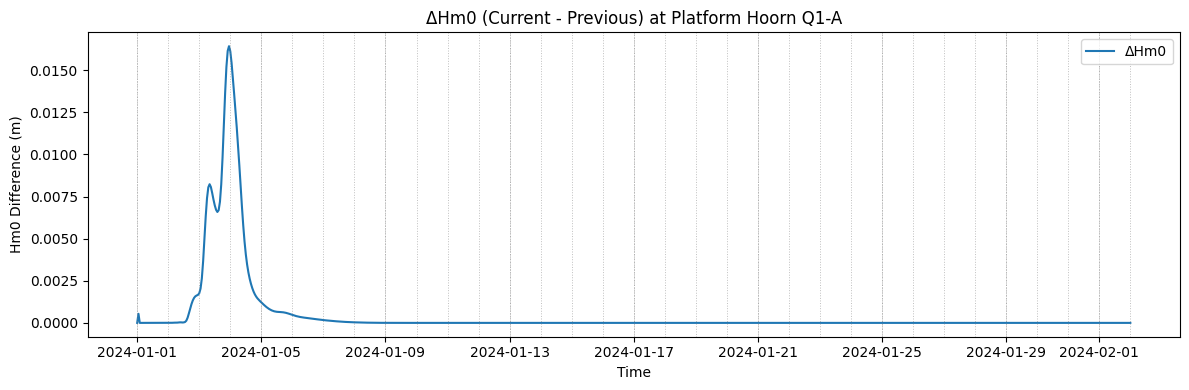

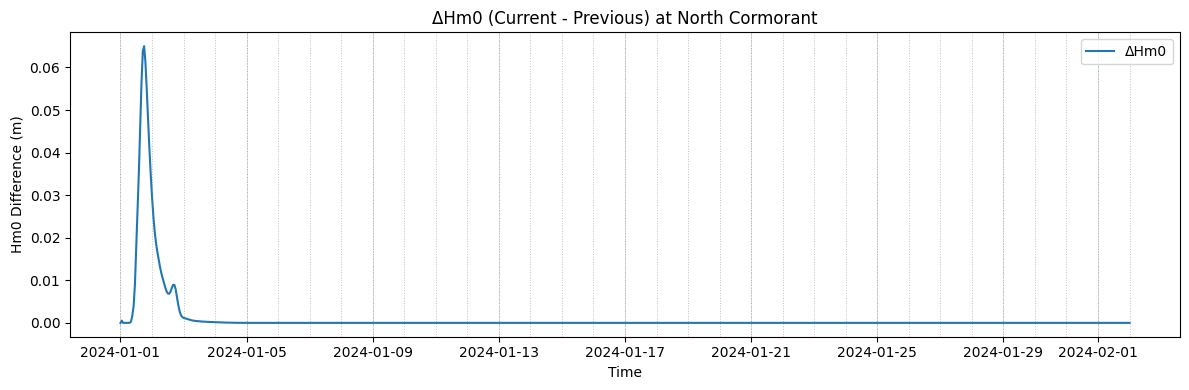

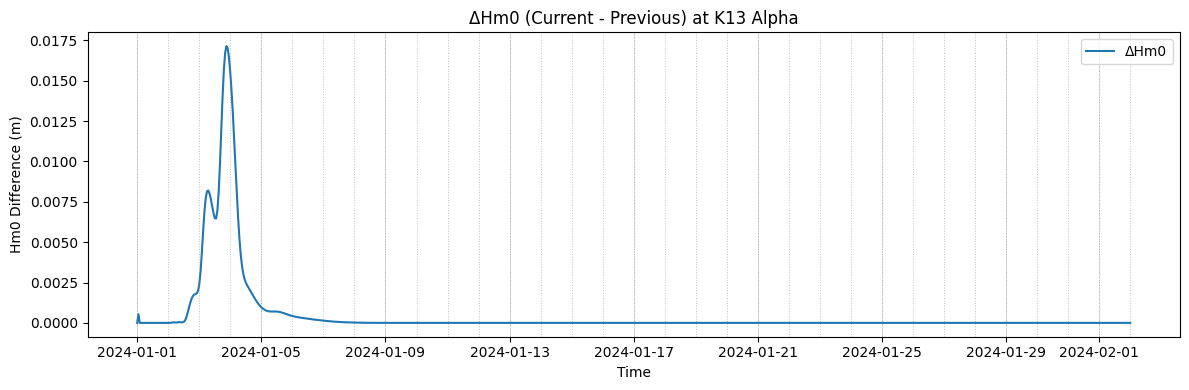

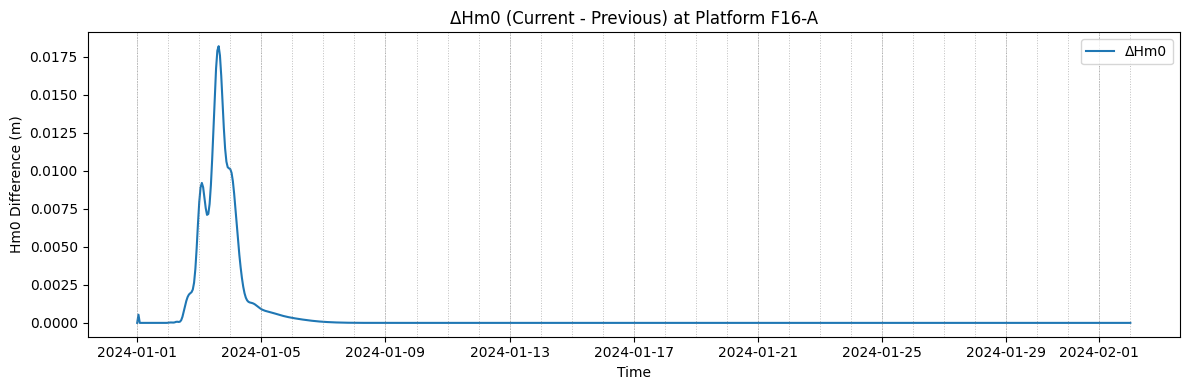

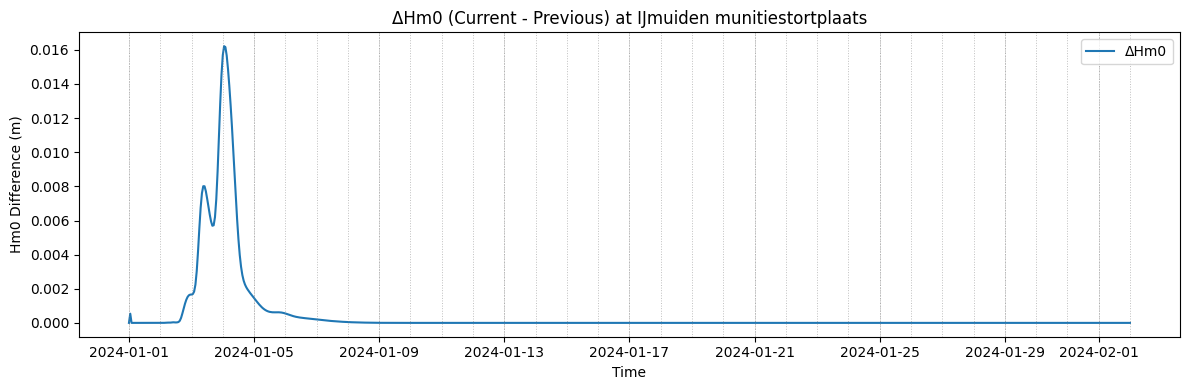

In [48]:
for station in station_list_model:
    hm0 = df_model[station]['point_hm0']
    time = df_model[station]['time']
    diff_hm0 = np.diff(hm0, prepend=hm0[0])  # prepend first value to keep array length

    # Save the first graph only
    if station == station_list_model[0]:
        plt.figure(figsize=(12, 4))
        plt.plot(time, diff_hm0, label='ΔHm0')
        plt.title(f"ΔHm0 (Current - Previous) at {station}")
        plt.xlabel("Time")
        plt.ylabel("Hm0 Difference (m)")
        plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5, alpha=0.7)
        days = np.array([pd.Timestamp(t).normalize() for t in time])
        unique_days = np.unique(days)
        for day in unique_days:
            plt.axvline(day, color='gray', linestyle=':', linewidth=0.7, alpha=0.5)
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "output.png"))
        plt.show()
    else:
        plt.figure(figsize=(12, 4))
        plt.plot(time, diff_hm0, label='ΔHm0')
        plt.title(f"ΔHm0 (Current - Previous) at {station}")
        plt.xlabel("Time")
        plt.ylabel("Hm0 Difference (m)")
        plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5, alpha=0.7)
        days = np.array([pd.Timestamp(t).normalize() for t in time])
        unique_days = np.unique(days)
        for day in unique_days:
            plt.axvline(day, color='gray', linestyle=':', linewidth=0.7, alpha=0.5)
        plt.legend()
        plt.tight_layout()
        plt.show()

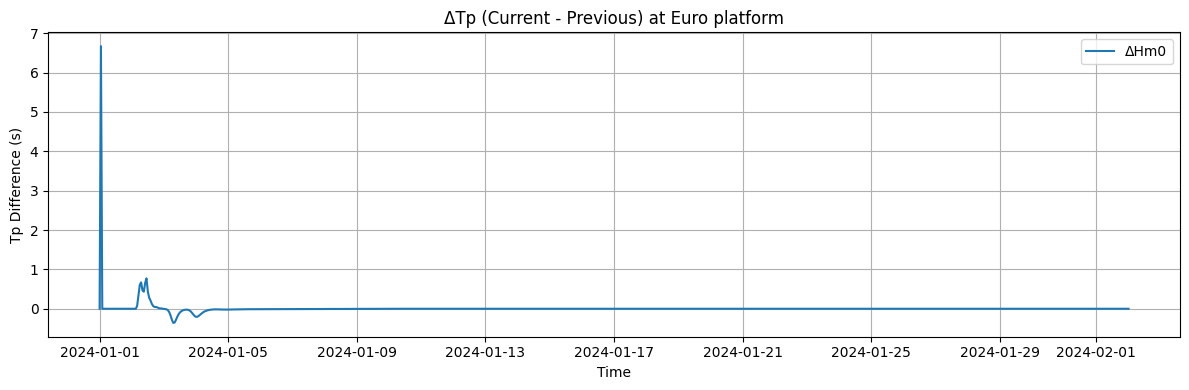

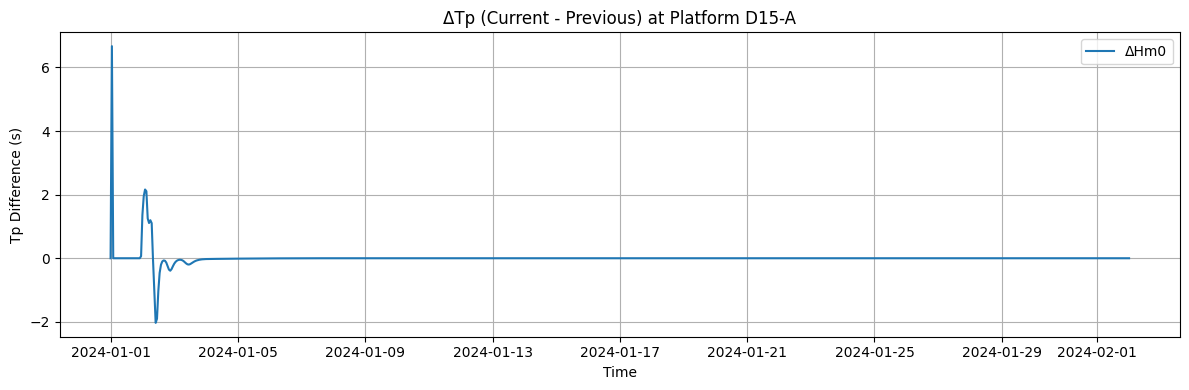

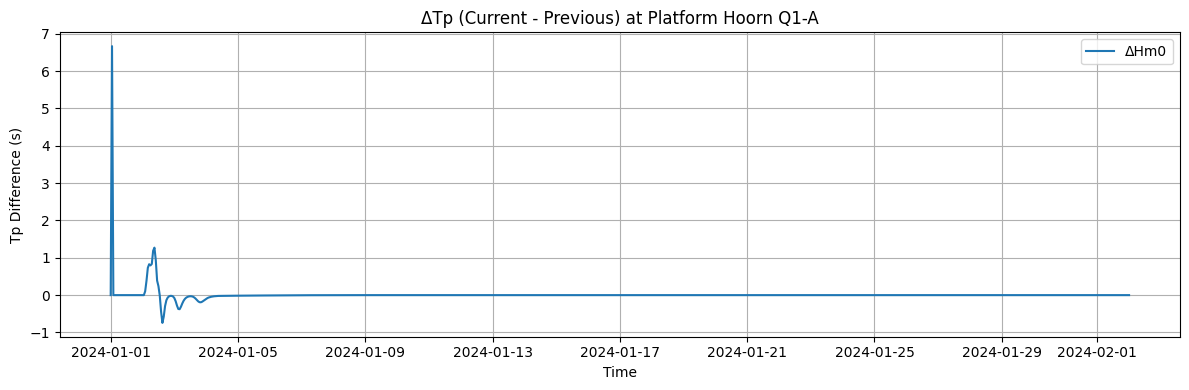

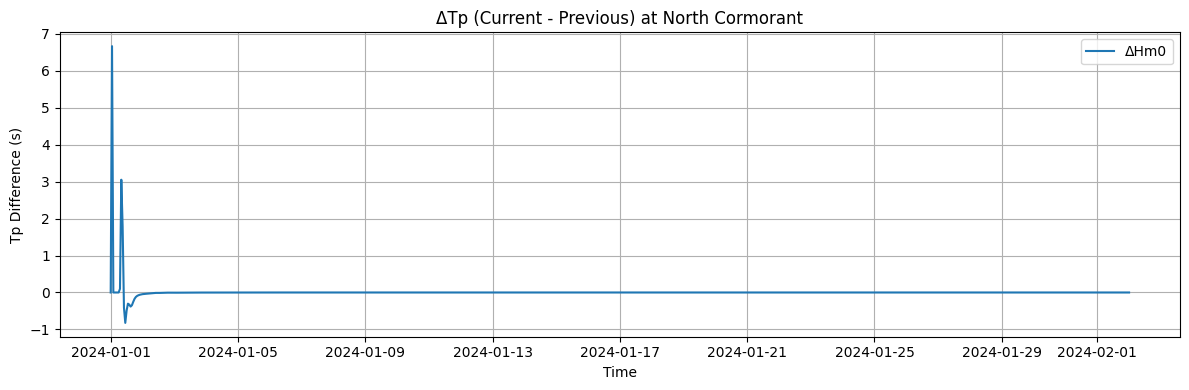

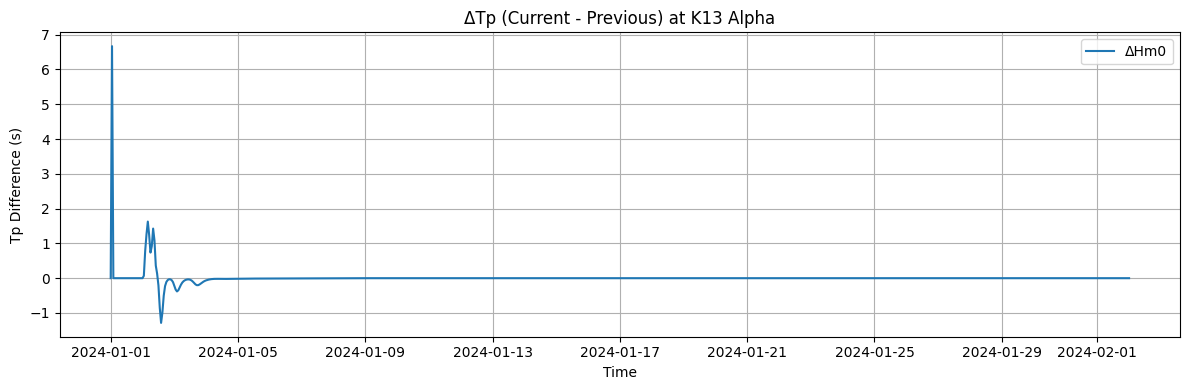

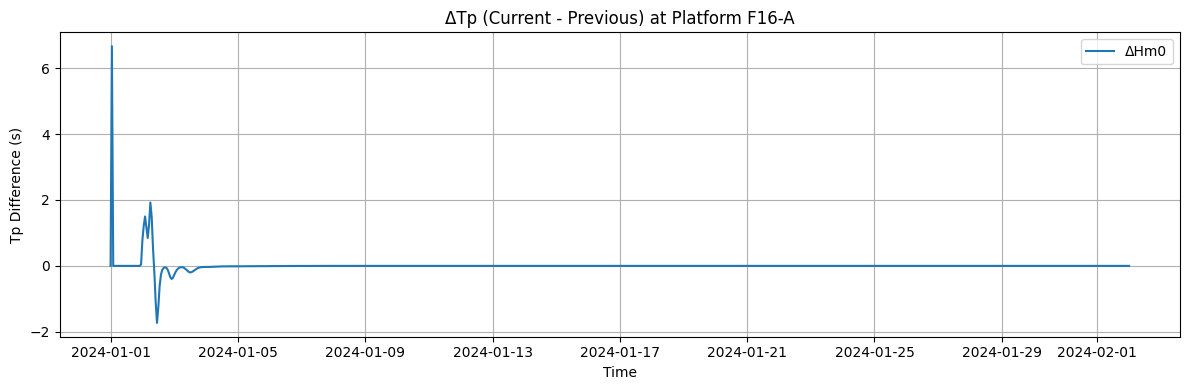

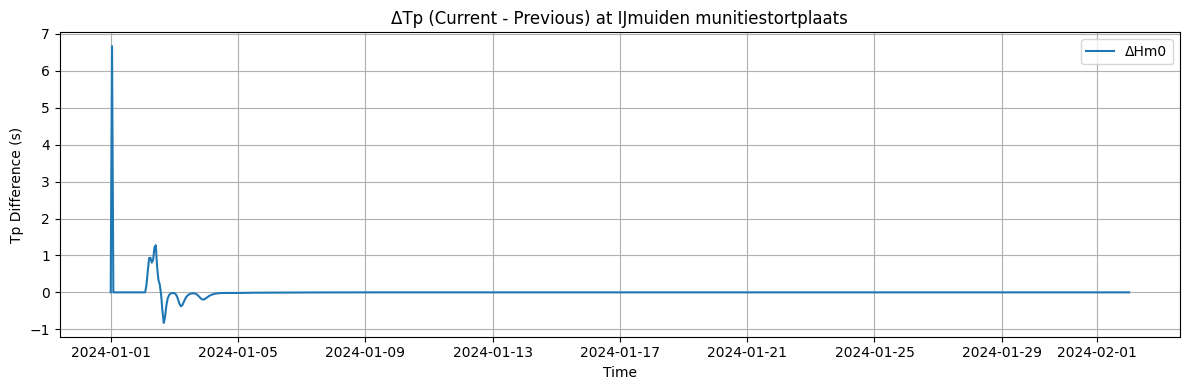

In [49]:
for station in station_list_model:
    hm0 = df_model[station]['point_tp']
    time = df_model[station]['time']
    diff_hm0 = np.diff(hm0, prepend=hm0[0])  # prepend first value to keep array length

    plt.figure(figsize=(12, 4))
    plt.plot(time, diff_hm0, label='ΔHm0')
    plt.title(f"ΔTp (Current - Previous) at {station}")
    plt.xlabel("Time")
    plt.ylabel("Tp Difference (s)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

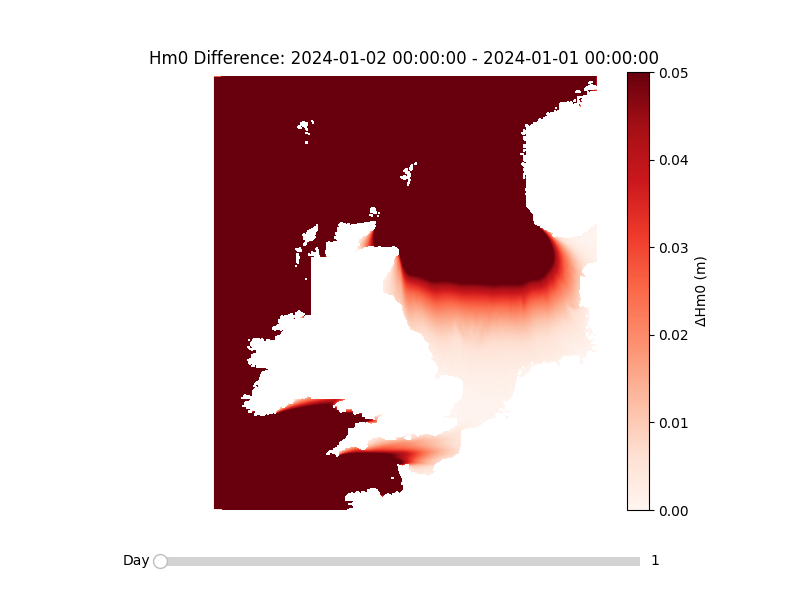

In [50]:
from matplotlib.widgets import Slider
# For VSCode/Jupyter, use %matplotlib widget for interactive sliders
%matplotlib widget

# Calculate daily mean Hm0 for each day
hm0 = modig['Hm0'].values  # shape: (time, n, m)
times = modig['Hm0'].coords['time'].values
days = np.array([pd.Timestamp(t).normalize() for t in times])
unique_days = np.unique(days)

# Compute daily mean for each day
daily_means = []
for d in unique_days:
    mask = days == d
    daily_means.append(hm0[mask].mean(axis=0))
daily_means = np.array(daily_means)  # shape: (num_days, n, m)

# Compute differences between consecutive days
diffs = np.diff(daily_means, axis=0)  # shape: (num_days-1, n, m)

# Interactive plot with slider
fig, ax = plt.subplots(figsize=(8, 6))
plt.subplots_adjust(bottom=0.15)
vmax = np.nanmax(diffs)
cax = ax.imshow(diffs[0], cmap='Reds', vmin=0, vmax=0.05)
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('ΔHm0 (m)')

ax.set_title(f'Hm0 Difference: {unique_days[1]} - {unique_days[0]}')
ax.axis('off')
ax.invert_yaxis()  # Invert the y axis so north is at the top

# Slider
ax_slider = plt.axes([0.2, 0.05, 0.6, 0.03])
slider = Slider(ax_slider, 'Day', 1, len(unique_days)-1, valinit=1, valstep=1)

def update(val):
    idx = int(slider.val) - 1
    cax.set_data(diffs[idx])
    ax.set_title(f'Hm0 Difference: {unique_days[idx+1]} - {unique_days[idx]}')
    fig.canvas.draw_idle()

slider.on_changed(update)
plt.show()

In [31]:
def extract_multiple_his(his_filepaths, model_names,station_names):
    """
    Extract data from multiple xarray Datasets into a nested dictionary:
    df[model_name][station][variable] = values

    Parameters:
    - his_filepaths: list of file paths to xarray datasets
    - model_names: list of model names (same length as his_filepaths)

    Returns:
    - dict of dicts: df[model_name][station][variable] = values
    """
    all_data = {}

    for filepath, model_name in zip(his_filepaths, model_names):
        ds = xr.open_dataset(filepath)
        ds = ds.assign_coords({"stations": station_names})
        station_data = extract_data(ds)
        all_data[model_name] = station_data
        ds.close()

    return all_data

In [32]:
his_files = [
    os.path.join(base_path, '04_modelruns', 'spinup_test_bnd_mild', 'hurrywave_his.nc'),
    os.path.join(base_path, '04_modelruns', 'spinup_test_nobnd_mild', 'hurrywave_his.nc'),
    os.path.join(base_path, '04_modelruns', 'spinup_test_nobnd_storm', 'hurrywave_his.nc'),
    os.path.join(base_path, '04_modelruns', 'spinup_test_nowind', 'hurrywave_his.nc')
]

all_data = extract_multiple_his(his_files, ['Run_1', 'Run_2', 'Run_3', 'Run_4'], station_names)

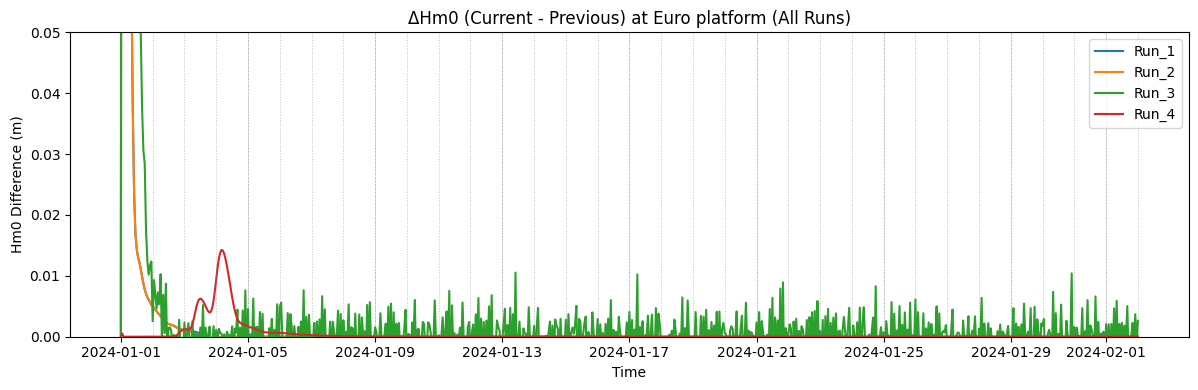

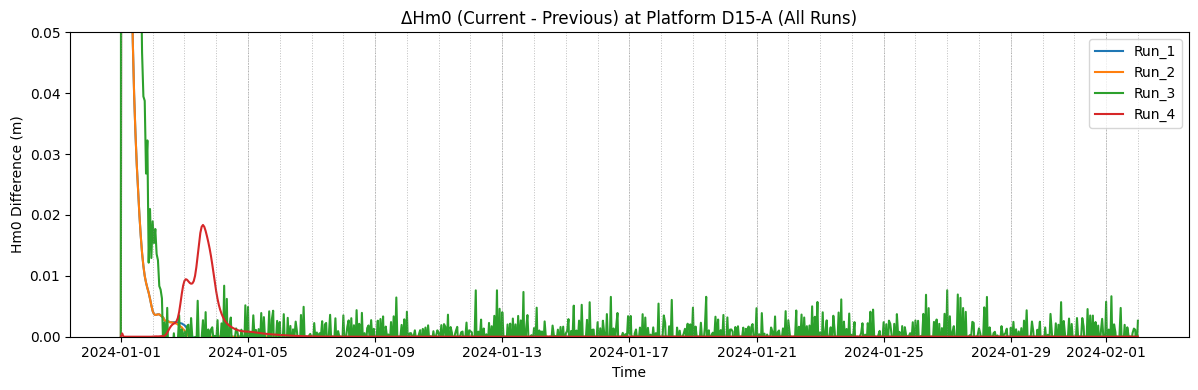

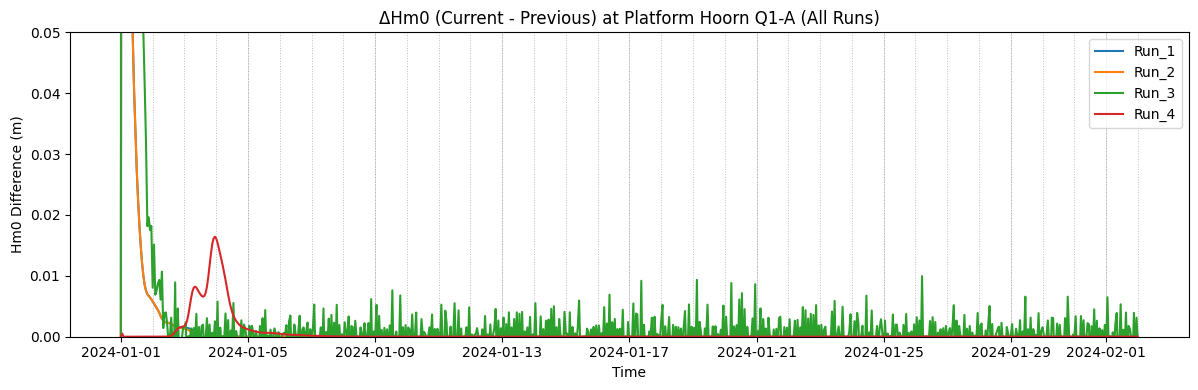

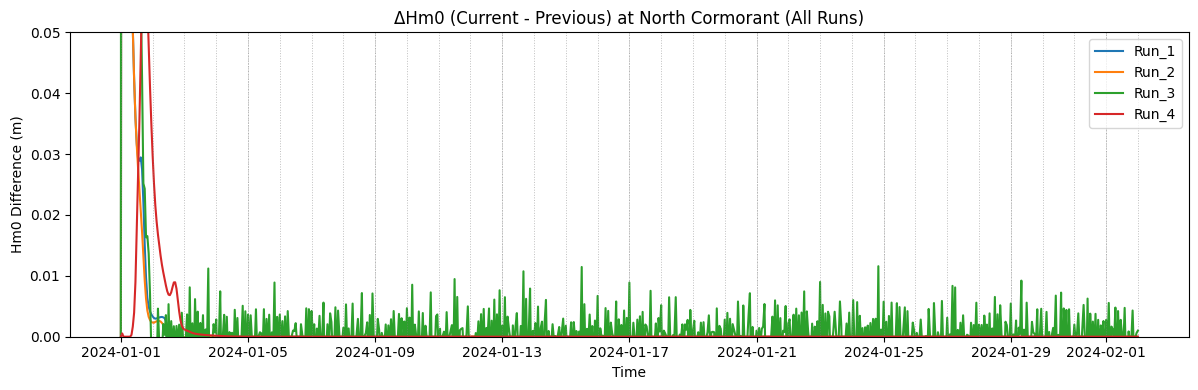

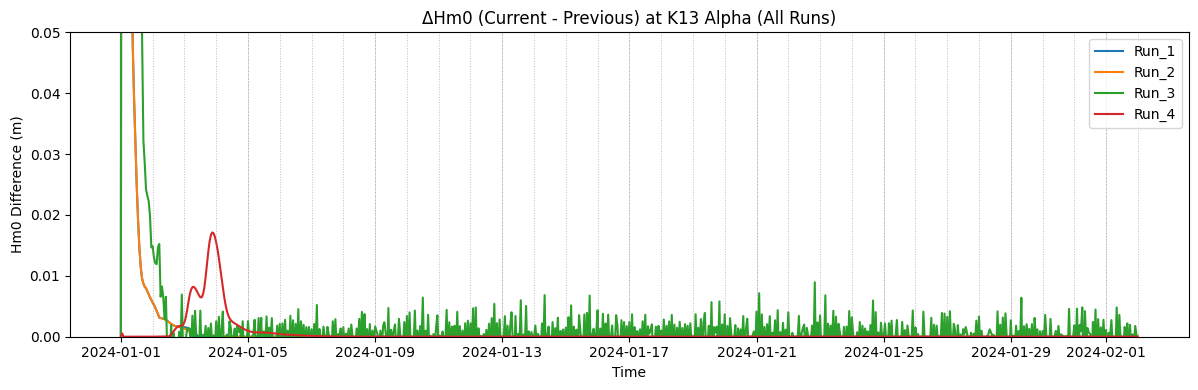

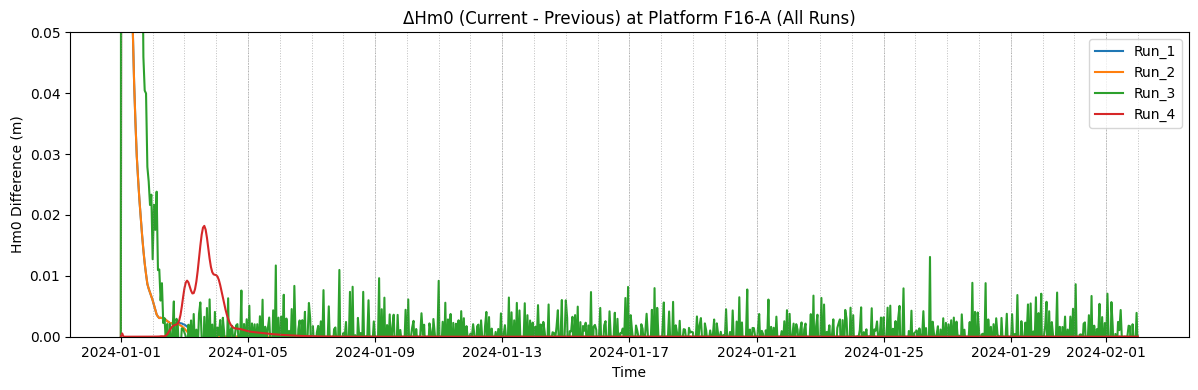

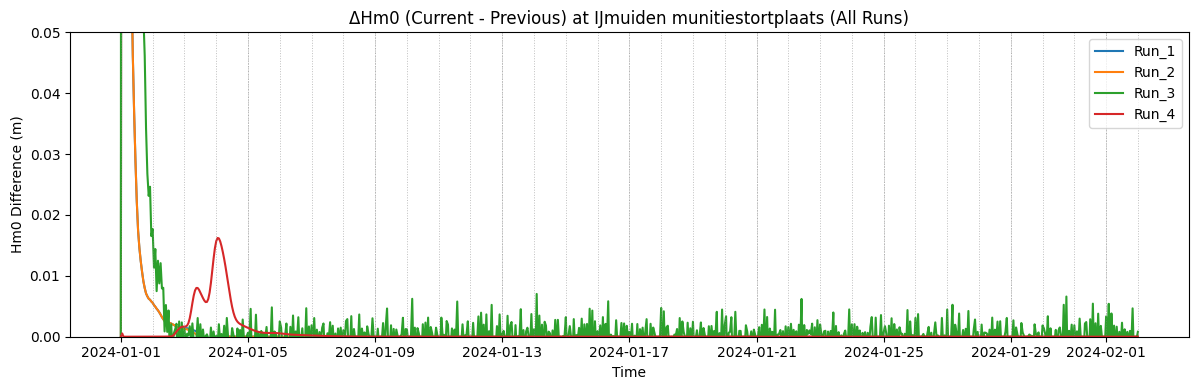

In [34]:
for station in station_list_model:
    plt.figure(figsize=(12, 4))
    for run_name, run_data in all_data.items():
        hm0 = run_data[station]['point_hm0']
        time = run_data[station]['time']
        diff_hm0 = np.diff(hm0, prepend=hm0[0])
        plt.plot(time, diff_hm0, label=run_name)
    plt.title(f"ΔHm0 (Current - Previous) at {station} (All Runs)")
    plt.xlabel("Time")
    plt.ylabel("Hm0 Difference (m)")
    plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5, alpha=0.7)
    days = np.array([pd.Timestamp(t).normalize() for t in time])
    unique_days = np.unique(days)
    for day in unique_days:
        plt.axvline(day, color='gray', linestyle=':', linewidth=0.7, alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.ylim(0, 0.050)
    plt.show()


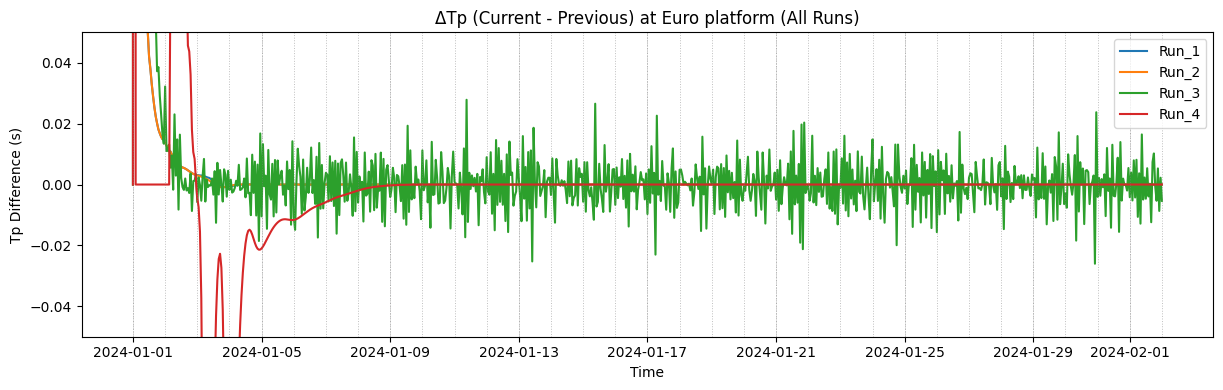

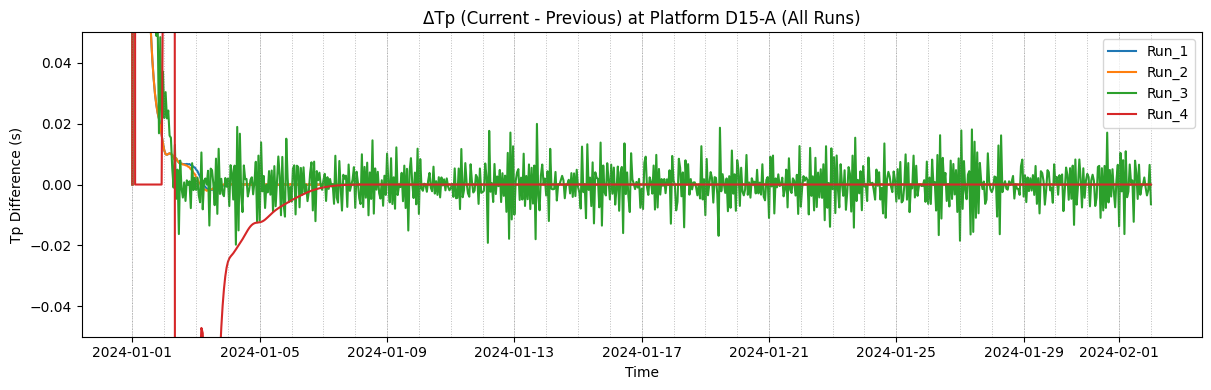

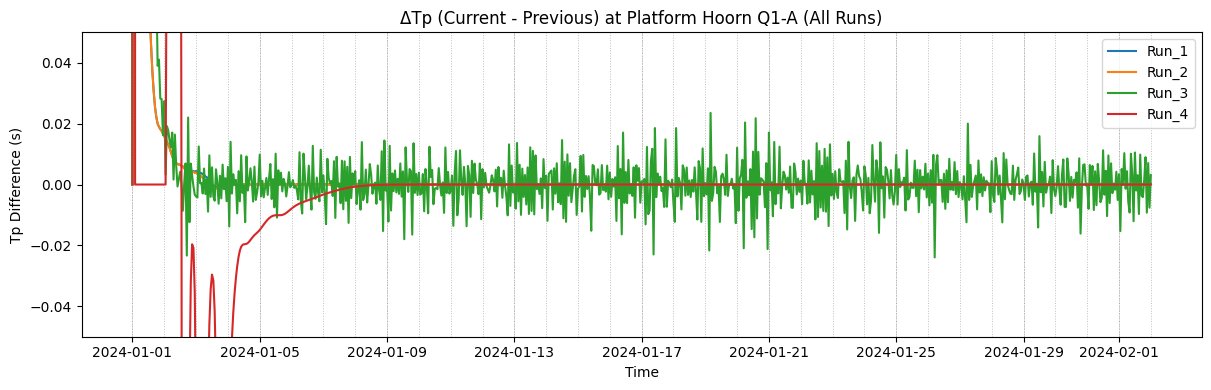

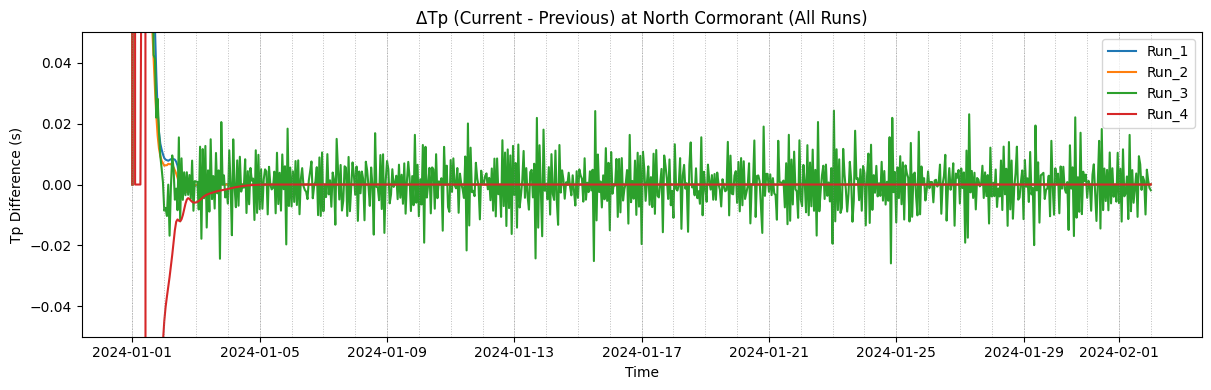

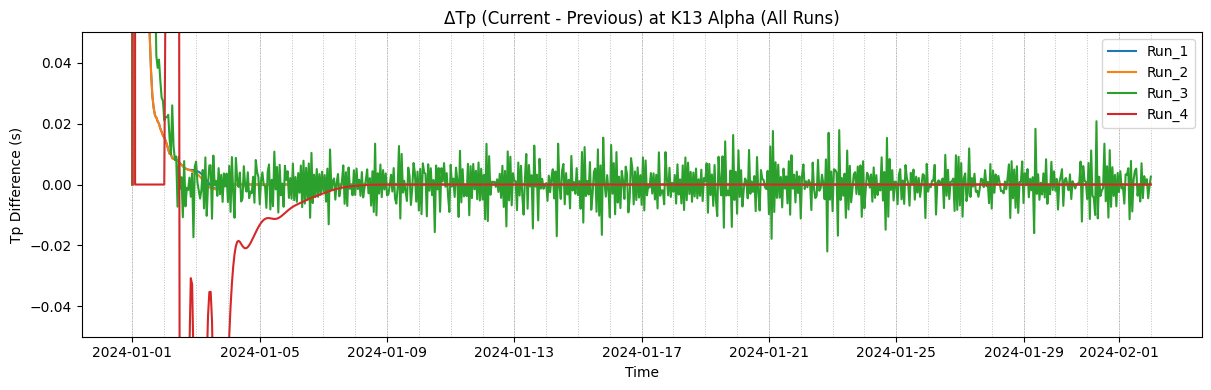

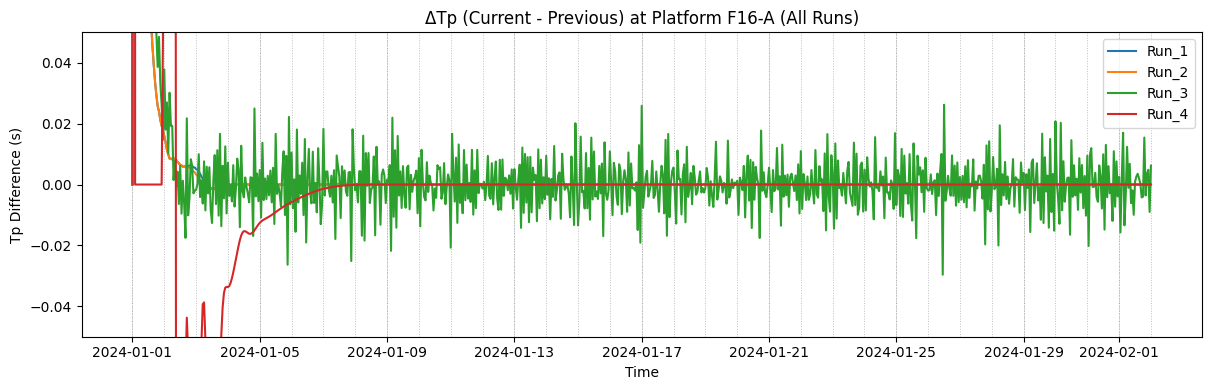

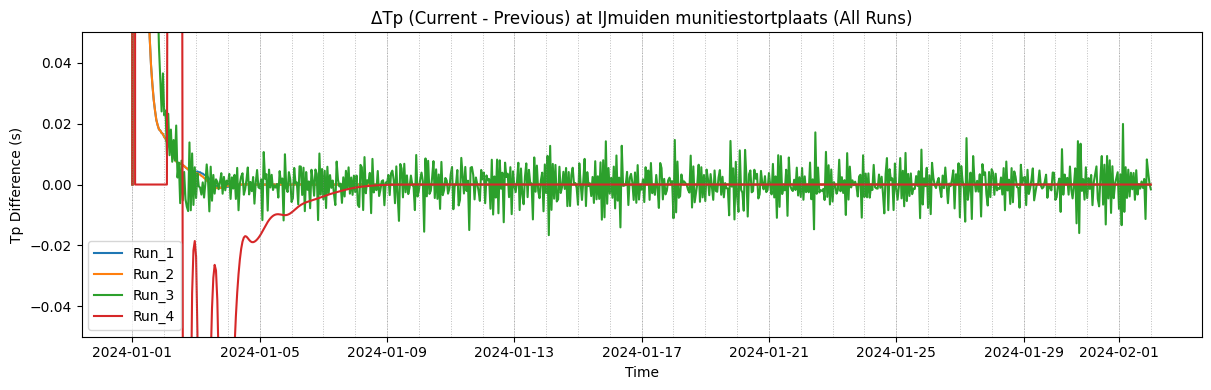

In [37]:
for station in station_list_model:
    plt.figure(figsize=(12, 4))
    for run_name, run_data in all_data.items():
        tp = run_data[station]['point_tp']
        time = run_data[station]['time']
        diff_tp = np.diff(tp, prepend=tp[0])
        plt.plot(time, diff_tp, label=run_name)
    plt.title(f"ΔTp (Current - Previous) at {station} (All Runs)")
    plt.xlabel("Time")
    plt.ylabel("Tp Difference (s)")
    plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5, alpha=0.7)
    days = np.array([pd.Timestamp(t).normalize() for t in time])
    unique_days = np.unique(days)
    for day in unique_days:
        plt.axvline(day, color='gray', linestyle=':', linewidth=0.7, alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.ylim(-0.05, 0.05)
    plt.show()
